### Importing Everything Require

In [1]:
import warnings
import os
from helper import get_detail, plot33, tr_plot

warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay

2021-12-01 09:55:28.948315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Getting and knowing dataset

In [3]:
project_root = os.path.abspath("..")
TRAIN_DIR = project_root + '/backend/train'
VALID_DIR = project_root + '/backend/test'
IMAGE_SIZE = (25,25)

#### Exploring Dataset

In [4]:
train_images = get_detail(TRAIN_DIR,'training')

We have 1700 training images for 0
We have 1700 training images for 1
We have 1700 training images for 2
We have 1700 training images for 3
We have 1700 training images for 4
We have 1700 training images for 5
We have 1700 training images for 6
We have 1700 training images for 7
We have 1700 training images for 8
We have 1700 training images for 9


In [5]:
val_images = get_detail(VALID_DIR,'validation')

We have 300 validation images for 0
We have 300 validation images for 1
We have 300 validation images for 2
We have 300 validation images for 3
We have 300 validation images for 4
We have 300 validation images for 5
We have 300 validation images for 6
We have 300 validation images for 7
We have 300 validation images for 8
We have 300 validation images for 9


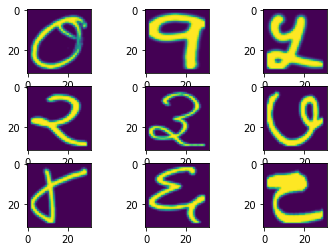

In [6]:
plot33(TRAIN_DIR,train_images)

#### Getting Dataset

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255, rotation_range=90,
    horizontal_flip=True, vertical_flip=True,
    fill_mode='nearest', validation_split=0.1,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, batch_size=16, color_mode='grayscale',
    target_size=IMAGE_SIZE, subset='training',
)

test_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, batch_size=16,color_mode='grayscale',
    target_size=IMAGE_SIZE, subset='validation',
)

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(VALID_DIR,batch_size=16,
                                                                        target_size=IMAGE_SIZE,
                                                                        color_mode='grayscale',
                                                                        shuffle=False)

Found 15300 images belonging to 10 classes.
Found 1700 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


### Creating Model

In [8]:
NUM_EPOCH = 25
LR = 0.0001
INPUT_SHAPE = (25,25,1)
ACT_FUNCTION = 'relu'
RESULT_ACT_FUNCTION = 'softmax'

In [9]:
def poly_decay( epoch):
    maxEpochs = NUM_EPOCH
    baseLR = LR
    power = 1
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha
    
inp = tf.keras.Input(shape=INPUT_SHAPE)

x = layers.Conv2D(128, (5, 5), activation=ACT_FUNCTION, padding='same')(inp)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation=ACT_FUNCTION, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation=ACT_FUNCTION)(x)

encoder = tf.keras.Model(inputs=inp, outputs=x)

inp = tf.keras.Input(shape=(25, 25, 1))
x = encoder(inp)
out = layers.Dense(10, activation=RESULT_ACT_FUNCTION)(x)

model = tf.keras.Model(inputs=inp, outputs=out)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
             loss='categorical_crossentropy',
             metrics=['acc']
             )

model.summary()

2021-12-01 09:55:51.169771: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-01 09:55:51.182889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-01 09:55:51.280995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 09:55:51.281737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce 930MX computeCapability: 5.0
coreClock: 1.0195GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 13.41GiB/s
2021-12-01 09:55:51.281763: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-01 09:55:51.345482: I tensorflow/stream_executor/platform/defaul

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 128)               891904    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 893,194
Trainable params: 891,658
Non-trainable params: 1,536
_________________________________________________________________


In [10]:
checkpoint = [
    ModelCheckpoint('best-model.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto'),
    LearningRateScheduler(poly_decay,verbose=1)
]

### Trainning and Saving 

In [11]:
history = model.fit(
    train_generator,
    epochs=NUM_EPOCH,
    validation_data=test_generator,
    callbacks=checkpoint
)

2021-12-01 09:56:10.915037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-01 09:56:10.936940: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.


2021-12-01 09:56:12.039477: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-01 09:56:13.451151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-12-01 09:56:13.477193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


957/957 [==============================] - 65s 58ms/step - loss: 2.1690 - acc: 0.2834 - val_loss: 1.3747 - val_acc: 0.5194

Epoch 00001: val_loss improved from inf to 1.37465, saving model to best-model.h5
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 9.6e-05.
957/957 [==============================] - 55s 57ms/step - loss: 1.2357 - acc: 0.5564 - val_loss: 0.7868 - val_acc: 0.7282

Epoch 00002: val_loss improved from 1.37465 to 0.78677, saving model to best-model.h5
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 9.200000000000001e-05.
957/957 [==============================] - 54s 57ms/step - loss: 0.8892 - acc: 0.6923 - val_loss: 0.6411 - val_acc: 0.7618

Epoch 00003: val_loss improved from 0.78677 to 0.64110, saving model to best-model.h5
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 8.800000000000001e-05.
957/957 [==============================] - 54s 56ms/step - loss: 0.6621 - acc: 0.7764 - val_loss: 0.

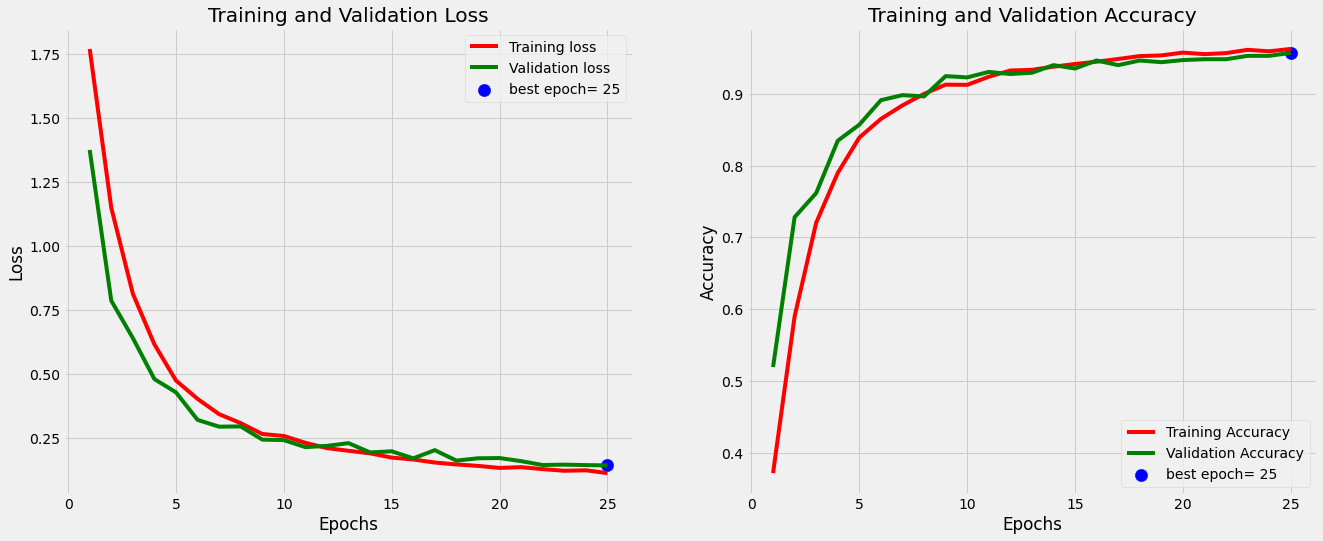

In [12]:
tr_plot(history,0)

## Evaluation

In [13]:
result = model.evaluate(val_generator)
print("Model Loss is {0:.2f} and accuracy is {1:.2f}% for testing data.".format(result[0],result[1]*100))

188/188 [==============================] - 4s 22ms/step - loss: 0.1018 - acc: 0.9717
Model Loss is 0.10 and accuracy is 97.17% for testing data.


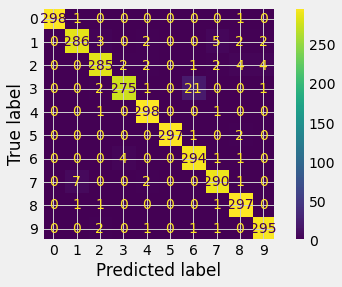

In [14]:
y_pred = model.predict(val_generator)

ConfusionMatrixDisplay.from_predictions(val_generator.classes, y_pred.argmax(axis=1))

### Testing with real image

In [15]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
model = load_model('best-model.h5')
# summarize model.
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 128)               891904    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 893,194
Trainable params: 891,658
Non-trainable params: 1,536
_________________________________________________________________


In [16]:
REAL_IMAGE_DIR = project_root + "/backend/real_image/"
_, _, files = next(os.walk(REAL_IMAGE_DIR))
list_of_image = [REAL_IMAGE_DIR+file for file in files]

In [27]:
len(list_of_image)

10

In [37]:
import numpy as np
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict(directory):
    
    img = load_img(directory, target_size=IMAGE_SIZE, grayscale=True)
    img = ImageOps.invert(img)
    img_arr = np.expand_dims(img_to_array(img), axis=0)
    datagen = ImageDataGenerator(rescale=1. / 255)
    dada = datagen.flow(img_arr, batch_size=1, shuffle=False)

    new_shape = (1,) + IMAGE_SIZE + (1,)
    final_image = tf.convert_to_tensor(dada[0].reshape(new_shape))

    conf = model.predict(final_image)
    pred = conf.argmax(axis=1)

    print("Predicted {} for {} with {:.2f}% confidence.".format(pred[0],directory[-5],conf[0][pred][0]*100))


for each in list_of_image:
    predict(each)

Predicted 9 for 1 with 59.94% confidence.
Predicted 0 for 0 with 99.90% confidence.
Predicted 6 for 3 with 70.68% confidence.
Predicted 9 for 9 with 99.79% confidence.
Predicted 2 for 2 with 35.65% confidence.
Predicted 8 for 8 with 99.38% confidence.
Predicted 5 for 5 with 99.64% confidence.
Predicted 6 for 6 with 98.55% confidence.
Predicted 7 for 7 with 98.63% confidence.
Predicted 2 for 4 with 70.80% confidence.


WE CAN SEE, NUMBERS 1, 3 AND 4 ARE INCORRECTLY CLASSIFIED. <br>
SO, 7 OUT OF 10 WERE CORRECTLY CLASSIFIED, FROM WHERE WE APPROXIMATE IT IS 70% ACCURATE ON REAL WORLD DATA.

### Reference

1. [How to Load Large Datasets From Directories for Deep Learning in Keras](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/)
2. [CNN classifier for MNIST](https://www.kaggle.com/vesran/cnn-classifier-for-mnist-0-99-acc-in-test)
3. [GitHub- Paint App with Flask and PostgreSQL](https://github.com/nidhinp/Paintapp-Flask-PostgreSQL)